In [1]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [2]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')

selected_features = ['Fwd IAT Total', 'Fwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

X_train = train_df[selected_features]  # Features from the training data
#X_train = train_df.drop(['Label', 'Attack'], axis=1)
y_train = train_df['Attack'] 

X_eval = eval_df[selected_features]  # Features from the evaluation data
#X_eval = eval_df.drop(['Label', 'Attack'], axis=1)
y_eval = eval_df['Attack']

X_test = test_df[selected_features]
#X_test = test_df.drop(['Label', 'Attack'], axis=1)
y_test = test_df['Attack']

# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Applying the 'trained' scaler on eval and test
X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# baseline models

In [2]:
def run_on_splits(func):
    def _run_loop(model, model_name):
        for X, y, nsplit in zip([X_train, X_eval], 
                                [y_train, y_eval],  
                                ['train', 'val']):
            func(model, X=X, y=y, nsplit=nsplit, model_name=model_name, beta=2)  # F2 score optimization
    return _run_loop

In [3]:
@run_on_splits 
def evaluate_splits(model, X, y, nsplit, model_name, beta=2):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)

    # Calculating F scores for the given beta
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)  # Using nanargmax to ignore NaNs in the calculation
    best_threshold = thresholds[best_idx]

    predictions = (probabilities >= best_threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)  # Handle zero division case
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec) + rec)
    roc_auc = roc_auc_score(y, probabilities) 

    # Store performances
    performances.append({
        'model': model_name,
        'split': nsplit,
        'threshold': best_threshold,
        'accuracy': acc,'precision': prec,'recall': rec,'f1': f1,
        'f2': f2,'roc_auc': roc_auc,'beta': beta})

    if nsplit == 'val':
        report = classification_report(y, predictions)
        cm = confusion_matrix(y, predictions)

        # Save the classification report as TXT
        report_path = f'../output/baseline_evaluation/{model_name}_classification_report.txt'
        with open(report_path, 'w') as f:
            f.write(report)

        # Generate and save onfusion matrix
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])
        plt.tight_layout()
        
        matrix_path = f'../output/baseline_evaluation/{model_name}_confusion_matrix.png'
        plt.savefig(matrix_path)
        plt.close(fig)
        print(f"Saved confusion matrix for {model_name} at {matrix_path}")
    return

"""
def load_and_evaluate(model_filename, model_name):
model = load(model_filename)
evaluate(model, model_name=model_name)
"""

'\ndef load_and_evaluate(model_filename, model_name):\nmodel = load(model_filename)\nevaluate(model, model_name=model_name)\n'

In [6]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it."""
    model.fit(X_train, y_train)
    dump(model, filename)
    return model

In [7]:
# specify baseline models, with tuning from gridsearch
models = {
    'Dummy_Classifier': DummyClassifier(strategy='most_frequent', random_state=42),
    'Baseline_log_reg': LogisticRegression(max_iter=1000, random_state=42),
    'Baseline_SVM': svm.SVC(kernel='linear', probability=True, random_state=42),
    'Baseline_KNN': KNeighborsClassifier(n_neighbors=10),
    'Baseline_RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'Baseline_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
}

trained_models = {}  # Dictionary to store trained model references

for name, model in models.items():
    trained_model = train_and_save(model, X_train, y_train, f'../models/baseline_models/{name}.joblib')
    trained_models[name] = trained_model


In [8]:
performances = []  # To store performance results

for name, model in trained_models.items():
    evaluate_splits(model, model_name=name)

/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Saved confusion matrix for Dummy_Classifier at ../output/first_evaluation/Dummy_Classifier_confusion_matrix.jpeg
Saved confusion matrix for Baseline_log_reg at ../output/first_evaluation/Baseline_log_reg_confusion_matrix.jpeg
Saved confusion matrix for Baseline_SVM at ../output/first_evaluation/Baseline_SVM_confusion_matrix.jpeg
Saved confusion matrix for Baseline_KNN at ../output/first_evaluation/Baseline_KNN_confusion_matrix.jpeg
Saved confusion matrix for Baseline_RF at ../output/first_evaluation/Baseline_RF_confusion_matrix.jpeg
Saved confusion matrix for Tuned_RF at ../output/first_evaluation/Tuned_RF_confusion_matrix.jpeg
Saved confusion matrix for Baseline_XGB at ../output/first_evaluation/Baseline_XGB_confusion_matrix.jpeg
Saved confusion matrix for Tuned_XGB at ../output/first_evaluation/Tuned_XGB_confusion_matrix.jpeg


In [86]:
perf_df = pd.DataFrame(performances)
perf_df

,model,features,threshold,accuracy,precision,recall,f1,f2,roc_auc
0,Baseline_RF_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.780000,0.992433,0.967478,0.983363,0.975356,0.980144,0.997887
1,Tuned_RF_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.629748,0.991567,0.960709,0.984895,0.972652,0.979961,0.999043
2,Tuned_RF_Permutation_Features,"[Fwd IAT Total, Bwd Packet Length Std, Bwd Pac...",0.610204,0.991567,0.961497,0.984019,0.972628,0.979431,0.999134
3,Baseline_XGB_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.877578,0.994633,0.988473,0.976138,0.982267,0.978581,0.999419
4,Tuned_XGB_All_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.992367,0.968878,0.981392,0.975095,0.978864,0.999329
5,Tuned_XGB_Permutation_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.828708,0.993300,0.978104,0.977890,0.977997,0.977932,0.999270
6,Tuned_XGB_RFECV_Features,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.992367,0.968878,0.981392,0.975095,0.978864,0.999329


verify results:

In [1]:
# plotting

def plot_model_splits(performances, metric='f2'):
    # Create DataFrame from performances and filter val set
    perf_df = pd.DataFrame(performances)
    val_perf = perf_df[perf_df['split'] == 'val'].sort_values(by=metric, ascending=False)

    # sort the full DataFrame based on the order of the val set performance
    perf_df['model'] = pd.Categorical(perf_df['model'], categories=val_perf['model'], ordered=True)
    perf_df = perf_df.sort_values('model')

    # Set up the plot 
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   y='model', 
                                   x=metric, 
                                   hue='split',
                                   style='split', 
                                   markers={       # Define markers for each split
                                       'train': 'o',
                                       'val': '^',
                                   },
                                   palette=['grey', 'darkorange'],
                                   alpha=0.8)  # Adjust alpha transparency for all markers

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    # Specify the plot path and save
    plt.tight_layout() 
    plot_path = f'../output/plots/{metric}_baseline_splits.jpeg'
    plt.savefig(plot_path)

    plt.show()
    return

def plot_model_metric(performances, metric='f2'):
    perf_df = pd.DataFrame(performances)
    
    # sort the full DataFrame based on the order of performance
    perf_df = perf_df.sort_values(by=metric, ascending=False)

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                    x=metric, 
                                    y='model',
                                    alpha=0.7)
    
    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    # Specify the plot path and save
    plt.tight_layout() 
    plot_path = f'../output/plots/{metric}_baseline.jpeg'
    plt.savefig(plot_path)
    plt.show()
    return

In [ ]:
for m in ['f1', 'f2', 'recall', 'precision', 'roc_auc', 'accuracy']:
    plot_model_splits(performances, metric = m)

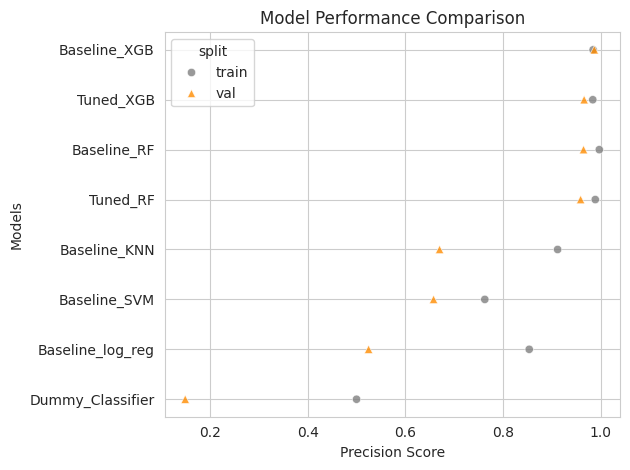

In [46]:
plot_model_splits(performances, metric='precision')
# update save in function

identify best models from baseline:

In [16]:
# Create DataFrame from performances
perf_df = pd.DataFrame(performances)

# Filter for test split and sort by F2 score
top_models = perf_df[perf_df['split'] == 'val'].sort_values(by='f2', ascending=False).head(4)
top_models

,model,split,threshold,accuracy,precision,recall,f1,f2,roc_auc,beta
11,Tuned_RF,val,0.629748,0.992200,0.958549,0.990629,0.974325,0.984043,0.998995,2
15,Tuned_XGB,val,0.783102,0.993067,0.965780,0.988621,0.977067,0.983967,0.999330,2
13,Baseline_XGB,val,0.877578,0.995467,0.986565,0.983043,0.984801,0.983746,0.999425,2
9,Baseline_RF,val,0.780000,0.992833,0.964511,0.988398,0.976309,0.983526,0.997880,2


Results for Tuned_RF:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     25518
           1       0.96      0.99      0.97      4482

    accuracy                           0.99     30000
   macro avg       0.98      0.99      0.98     30000
weighted avg       0.99      0.99      0.99     30000



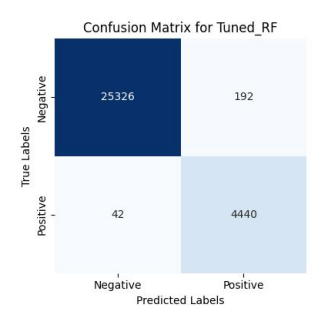

Results for Tuned_XGB:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     25518
           1       0.97      0.99      0.98      4482

    accuracy                           0.99     30000
   macro avg       0.98      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



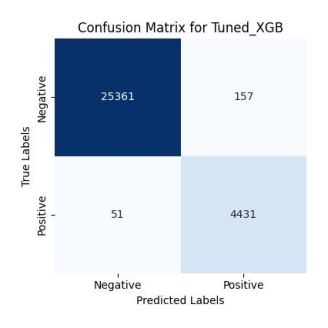

Results for Baseline_XGB:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25518
           1       0.99      0.98      0.98      4482

    accuracy                           1.00     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       1.00      1.00      1.00     30000



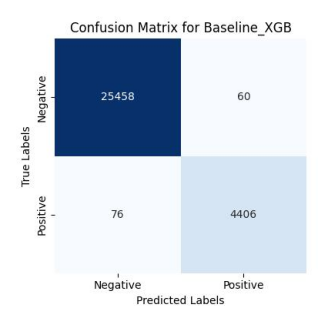

Results for Baseline_RF:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     25518
           1       0.96      0.99      0.98      4482

    accuracy                           0.99     30000
   macro avg       0.98      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



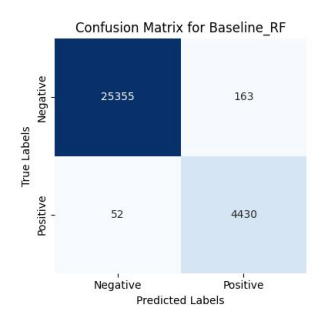

In [56]:
# loop over 'top_models' DataFrame and print cr and cm created above
for _, row in top_models.iterrows():
    model_name = row['model']
    # Construct paths based on how files were saved
    report_path = f'../output/baseline_evaluation/{model_name}_classification_report.txt'
    matrix_path = f'../output/baseline_evaluation/{model_name}_confusion_matrix.jpeg'

    # Load and print the classification report
    with open(report_path, 'r') as file:
        report = file.read()
    print(f"Results for {model_name}:\n{report}")

    # Display the confusion matrix image
    img = mpimg.imread(matrix_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()